In [3]:
# Importing required libraries 
# Keras
import keras
from keras import regularizers
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential, Model, model_from_json
from keras.layers import Dense, Embedding, LSTM
from keras.layers import Input, Flatten, Dropout, Activation, BatchNormalization
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.utils import np_utils, to_categorical
from keras.callbacks import ModelCheckpoint

# sklearn
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Other  
import librosa
import librosa.display
import json
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from matplotlib.pyplot import specgram
import pandas as pd
import seaborn as sns
import glob 
import os
import pickle
import IPython.display as ipd  # To play sound in the notebook

Using TensorFlow backend.


In [4]:
#Data paths

TESS = "C:/Users/Mi Notebook/Desktop/PavlodarCapture/speech_data/TESS Toronto emotional speech set data/"
RAV = "C:/Users/Mi Notebook/Desktop/PavlodarCapture/speech_data/audio_speech_actors_01-24/"
SAVEE = "C:/Users/Mi Notebook/Desktop/PavlodarCapture/speech_data/ALL/"
CREMA = "C:/Users/Mi Notebook/Desktop/PavlodarCapture/speech_data/AudioWAV/"

In [5]:
#Get SAVEE data

dir_list = os.listdir(SAVEE)

# 'a' - anger
# 'd' = disgust
# 'f' = fear
# 'h' = happiness
# 'n' = neutral
# 'sa' = sadness
# 'su' = surprise

path = []
emotions = []

for i in dir_list:
    
    emotion_type = i[-8:-6]
    
    add = False
    
    if emotion_type == '_a':
        emotions.append('male_angry')
        add = True
    elif emotion_type == '_d':
        emotions.append('male_disgust')
        add = True
    elif emotion_type == '_f':
        emotions.append('male_fear')
        add = True
    elif emotion_type == '_h':
        emotions.append('male_happy')
        add = True
    elif emotion_type == '_n':
        emotions.append('male_neutral')
        add = True
    elif emotion_type == 'sa':
        emotions.append('male_sad')
        add = True
    elif emotion_type == 'su':
        emotions.append('male_surprise')
        add = True

    assert add == True
    
    path.append(SAVEE + i)
    
SAVEE_df = pd.DataFrame(emotions, columns = ['labels'])
SAVEE_df['source'] = 'SAVEE'
SAVEE_df = pd.concat([SAVEE_df, pd.DataFrame(path, columns = ['path'])], axis = 1)
SAVEE_df.labels.value_counts()

male_neutral     120
male_fear         60
male_angry        60
male_sad          60
male_disgust      60
male_happy        60
male_surprise     60
Name: labels, dtype: int64

C:/Users/Mi Notebook/Desktop/PavlodarCapture/speech_data/ALL/DC_h11.wav


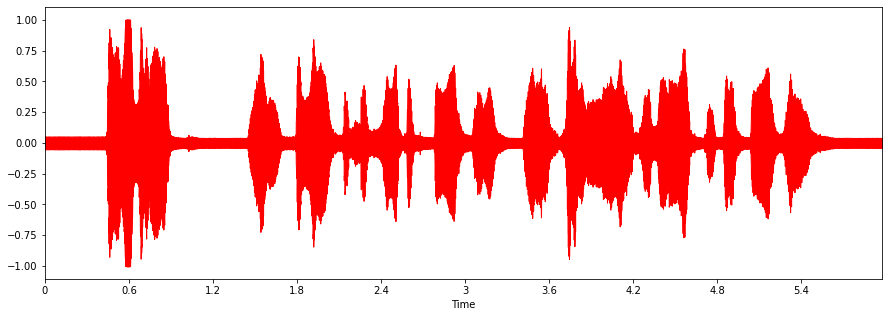

In [6]:
#Audio play from SAVEE

fname = SAVEE_df['path'][55]
print(fname)
data, sampling_rate = librosa.load(fname)
plt.figure(figsize=(15, 5))
librosa.display.waveplot(data, sr=sampling_rate, color='red')

ipd.Audio(fname)

In [9]:
# Get RAVDESS data

#01 - neutral, 
#02 - calm
#03 - happy
#04 - sad
#05 - angry
#06 - fearful
#07 - disgust
#08 - surprised

dir_list = os.listdir(RAV)
dir_list.sort()

emotions = []
gender = []
path = []
name = []

for i in dir_list:
    
    fname = os.listdir(RAV + i)
    
    for f in fname:
        
        part = f.split('.')[0].split('-')
        temp = int(part[6])
        
        if temp%2 == 0:
            temp = "female"
        else:
            temp = "male"
            
        emotion = part[2]
        add = False
        
        if emotion == '01' or emotion == '02':
            emotion = 'neutral'
            add = True
        elif emotion == '03':
            emotion = 'happy'
            add = True
        elif emotion == '04':
            emotion = 'sad'
            add = True
        elif emotion == '05':
            emotion = 'angry'
            add = True
        elif emotion == '06':
            emotion = 'fear'
            add = True
        elif emotion == '07':
            emotion = 'disgust'
            add = True
        elif emotion == '08':
            emotion = 'surprise'
            add = True
            
        assert add == True
        emotions.append(emotion)
        gender.append(temp)
        name.append(temp + '_' + emotion)
        path.append(RAV + i + '/' + f)
        
RAV_df = pd.DataFrame(name, columns = ['labels'])
RAV_df['source'] = 'RAVDESS'
RAV_df = pd.concat([RAV_df, pd.DataFrame(path, columns = ['path'])], axis=1)
RAV_df.labels.value_counts()

male_neutral       144
female_neutral     144
female_sad          96
female_surprise     96
female_happy        96
male_sad            96
male_surprise       96
male_fear           96
male_angry          96
male_disgust        96
female_angry        96
male_happy          96
female_disgust      96
female_fear         96
Name: labels, dtype: int64

C:/Users/Mi Notebook/Desktop/PavlodarCapture/speech_data/audio_speech_actors_01-24/Actor_14/03-01-06-02-02-02-14.wav


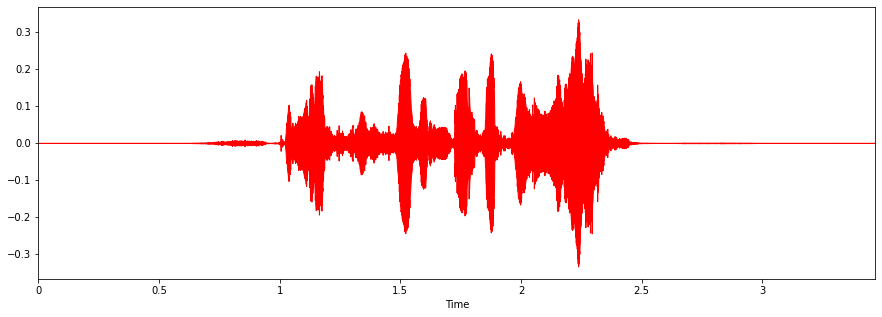

In [10]:
#Audio play from RAVDESS

fname = RAV_df['path'][823]
print(fname)
data, sampling_rate = librosa.load(fname)
plt.figure(figsize=(15, 5))
librosa.display.waveplot(data, sr=sampling_rate, color='red')

ipd.Audio(fname)

In [11]:
# Get TESS data

dir_list = os.listdir(TESS)
dir_list.sort()

emotions = []
path = []

for i in dir_list:
    
    fname = os.listdir(TESS + i)
    
    for f in fname:
        
        add = False
        
        if i == 'OAF_angry' or i == 'YAF_angry':
            emotions.append('female_angry')
            add = True
        elif i == 'OAF_disgust' or i == 'YAF_disgust':
            emotions.append('female_disgust')
            add = True
        elif i == 'OAF_Fear' or i == 'YAF_fear':
            emotions.append('female_fear')
            add = True
        elif i == 'OAF_happy' or i == 'YAF_happy':
            emotions.append('female_happy')
            add = True
        elif i == 'OAF_neutral' or i == 'YAF_neutral':
            emotions.append('female_neutral')    
            add = True
        elif i == 'OAF_Pleasant_surprise' or i == 'YAF_pleasant_surprised':
            emotions.append('female_surprise')   
            add = True
        elif i == 'OAF_Sad' or i == 'YAF_sad':
            emotions.append('female_sad')
            add = True
        
        assert add == True    
        path.append(TESS + i + "/" + f)
        
TESS_df = pd.DataFrame(emotions, columns = ['labels'])
TESS_df['source'] = 'TESS'
TESS_df = pd.concat([TESS_df, pd.DataFrame(path, columns = ['path'])], axis = 1)
TESS_df.labels.value_counts()

female_sad         400
female_happy       400
female_surprise    400
female_fear        400
female_neutral     400
female_angry       400
female_disgust     400
Name: labels, dtype: int64

C:/Users/Mi Notebook/Desktop/PavlodarCapture/speech_data/TESS Toronto emotional speech set data/YAF_fear/YAF_pick_fear.wav


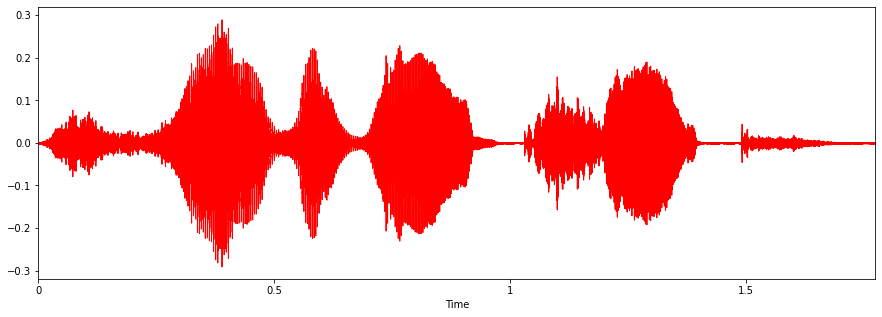

In [12]:
#Audio play from TESS

fname = TESS_df['path'][1923]
print(fname)
data, sampling_rate = librosa.load(fname)
plt.figure(figsize=(15, 5))
librosa.display.waveplot(data, sr=sampling_rate, color='red')

ipd.Audio(fname)

In [13]:
# Get CREMA data

dir_list = os.listdir(CREMA)
dir_list.sort()

emotions = []
path = []
female = [1002,1003,1004,1006,1007,1008,1009,1010,1012,1013,1018,1020,1021,1024,1025,1028,1029,1030,1037,1043,1046,1047,1049,
          1052,1053,1054,1055,1056,1058,1060,1061,1063,1072,1073,1074,1075,1076,1078,1079,1082,1084,1089,1091]

for i in dir_list: 
    
    part = i.split('_')
    
    if int(part[0]) in female:
        temp = 'female'
    else:
        temp = 'male'
        
    add = False
    emotion = 0
    
    if part[2] == 'SAD':
        emotion = 'sad'
        add = True
    elif part[2] == 'ANG':
        emotion = 'angry'
        add = True
    elif part[2] == 'DIS':
        emotion = 'disgust'
        add = True
    elif part[2] == 'FEA':
        emotion = 'fear'
        add = True
    elif part[2] == 'HAP':
        emotion = 'happy'
        add = True
    elif part[2] == 'NEU':
        emotion = 'neutral'
        add = True
    
    assert add == True
    
    emotions.append(temp + '_' + emotion)
    path.append(CREMA + i)
    
CREMA_df = pd.DataFrame(emotions, columns = ['labels'])
CREMA_df['source'] = 'CREMA'
CREMA_df = pd.concat([CREMA_df, pd.DataFrame(path, columns = ['path'])], axis = 1)
CREMA_df.labels.value_counts()

male_angry        671
male_sad          671
male_disgust      671
male_happy        671
male_fear         671
female_sad        600
female_happy      600
female_fear       600
female_angry      600
female_disgust    600
male_neutral      575
female_neutral    512
Name: labels, dtype: int64

C:/Users/Mi Notebook/Desktop/PavlodarCapture/speech_data/AudioWAV/1012_IEO_HAP_HI.wav


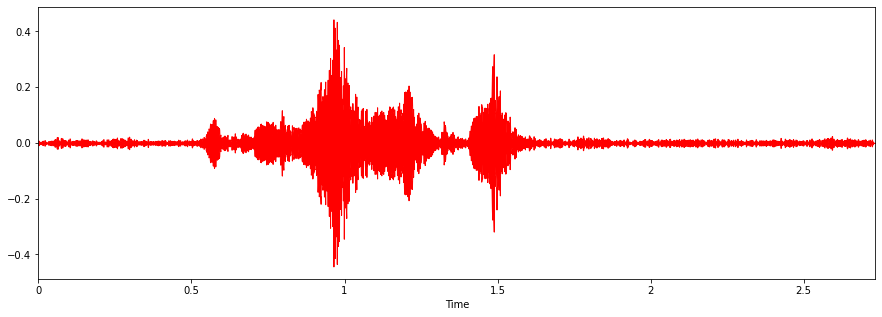

In [14]:
#Audio play from CREMA

fname = CREMA_df['path'][904]
print(fname)
data, sampling_rate = librosa.load(fname)
plt.figure(figsize=(15, 5))
librosa.display.waveplot(data, sr=sampling_rate, color='red')

ipd.Audio(fname)

In [15]:
#Merge all data

df = pd.concat([SAVEE_df, RAV_df, TESS_df, CREMA_df], axis = 0)
df.labels.value_counts()

female_sad         1096
female_fear        1096
female_angry       1096
female_happy       1096
female_disgust     1096
female_neutral     1056
male_neutral        839
male_angry          827
male_fear           827
male_sad            827
male_disgust        827
male_happy          827
female_surprise     496
male_surprise       156
Name: labels, dtype: int64

In [16]:
df

,labels,source,path
0,male_angry,SAVEE,C:/Users/Mi Notebook/Desktop/PavlodarCapture/s...
1,male_angry,SAVEE,C:/Users/Mi Notebook/Desktop/PavlodarCapture/s...
2,male_angry,SAVEE,C:/Users/Mi Notebook/Desktop/PavlodarCapture/s...
3,male_angry,SAVEE,C:/Users/Mi Notebook/Desktop/PavlodarCapture/s...
4,male_angry,SAVEE,C:/Users/Mi Notebook/Desktop/PavlodarCapture/s...
5,male_angry,SAVEE,C:/Users/Mi Notebook/Desktop/PavlodarCapture/s...
6,male_angry,SAVEE,C:/Users/Mi Notebook/Desktop/PavlodarCapture/s...
7,male_angry,SAVEE,C:/Users/Mi Notebook/Desktop/PavlodarCapture/s...
8,male_angry,SAVEE,C:/Users/Mi Notebook/Desktop/PavlodarCapture/s...
9,male_angry,SAVEE,C:/Users/Mi Notebook/Desktop/PavlodarCapture/s...


In [17]:
print(f'Total size of data = {len(df)}')

Total size of data = 12162


In [18]:
df.to_csv('out.csv')